# Exercise 2 - ANN classification

Dataset: https://www.kaggle.com/datasets/priyamchoksi/adult-census-income-dataset?resource=download

For this exercise I have selected a dataset about the income of US citizens. The target variable is income which is split into two groups, >50k and <50k. 

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [165]:
df = pd.read_csv("adult.csv", na_values="?") # I asked ChatGPT how I can set the "?" as null values so I can work with df.isnull().sum()
df.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,NaN,77053,HS-grad,9,Widowed,NaN,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,NaN,186061,Some-college,10,Widowed,NaN,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [166]:
df.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [167]:
df.shape[0]

32561

In [168]:
df.duplicated().sum()

np.int64(24)

I have 32 561 rows of data in this dataset, 24 duplicate entries and missing values only in the variables "workclass", "occupation" and "native.country". Since I have more than 30 000 rows of data I think I can just remove the null values and duplicates and still have enough data left over.

In [169]:
df = df.drop_duplicates()

In [170]:
df.duplicated().sum()

np.int64(0)

In [171]:
df = df.dropna()

In [172]:
df.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64

In [173]:
df["income"].value_counts()

income
<=50K    22633
>50K      7506
Name: count, dtype: int64

### Checking and correcting each Variable

#### Age

In [174]:
df["age"].value_counts()

age
36    852
31    851
33    837
34    836
37    828
     ... 
82      7
83      5
88      3
85      3
86      1
Name: count, Length: 72, dtype: int64

Age is already a metric variable and has no missing values

#### workclass

In [175]:
df["workclass"].value_counts()

workclass
Private             22264
Self-emp-not-inc     2498
Local-gov            2067
State-gov            1279
Self-emp-inc         1074
Federal-gov           943
Without-pay            14
Name: count, dtype: int64

In [176]:
# I asked ChatGPT to combine the variables with less than 1000 mentions into one column called "other"
rare_classes = df['workclass'].value_counts()[df['workclass'].value_counts() < 1000].index
df['workclass'] = df['workclass'].replace(rare_classes, 'Other') 
df = pd.get_dummies(df, columns=['workclass'])

In [177]:
df.head()

,age,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,workclass_Local-gov,workclass_Other,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov
1,82,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K,False,False,True,False,False,False
3,54,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K,False,False,True,False,False,False
4,41,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K,False,False,True,False,False,False
5,34,216864,HS-grad,9,Divorced,Other-service,Unmarried,White,Female,0,3770,45,United-States,<=50K,False,False,True,False,False,False
6,38,150601,10th,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,40,United-States,<=50K,False,False,True,False,False,False


#### fnlwgt

In [178]:
df["fnlwgt"].value_counts()

fnlwgt
203488    13
164190    12
123011    12
121124    12
148995    12
          ..
113987     1
177669     1
63079      1
381895     1
436163     1
Name: count, Length: 20263, dtype: int64

#### education

In [179]:
df["education"].value_counts()

education
HS-grad         9834
Some-college    6669
Bachelors       5042
Masters         1626
Assoc-voc       1307
11th            1048
Assoc-acdm      1008
10th             820
7th-8th          556
Prof-school      542
9th              455
12th             377
Doctorate        375
5th-6th          287
1st-4th          149
Preschool         44
Name: count, dtype: int64

In [180]:
# I asked ChatGPT to combine 1st through 4th into elementary school, 5th through 8th into middle school and 9th through 12th into high school
education_map = {
    '1st-4th': 'Elementary-school',
    '5th-6th': 'Middle-school',
    '7th-8th': 'Middle-school',
    '9th': 'High-school',
    '10th': 'High-school',
    '11th': 'High-school',
    '12th': 'High-school'
}

df['education'] = df['education'].replace(education_map)

In [181]:
df['education'].value_counts()

education
HS-grad              9834
Some-college         6669
Bachelors            5042
High-school          2700
Masters              1626
Assoc-voc            1307
Assoc-acdm           1008
Middle-school         843
Prof-school           542
Doctorate             375
Elementary-school     149
Preschool              44
Name: count, dtype: int64

I am going to combine values with less than 1000 mentions into a column called other again, same as I did before

In [182]:
rare_education = df['education'].value_counts()[df['education'].value_counts() < 1000].index
df['education'] = df['education'].replace(rare_education, 'Other') 
df = pd.get_dummies(df, columns=['education'])

In [183]:
df.head()

,age,fnlwgt,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,...,workclass_Self-emp-not-inc,workclass_State-gov,education_Assoc-acdm,education_Assoc-voc,education_Bachelors,education_HS-grad,education_High-school,education_Masters,education_Other,education_Some-college
1,82,132870,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,...,False,False,False,False,False,True,False,False,False,False
3,54,140359,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,...,False,False,False,False,False,False,False,False,True,False
4,41,264663,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,...,False,False,False,False,False,False,False,False,False,True
5,34,216864,9,Divorced,Other-service,Unmarried,White,Female,0,3770,...,False,False,False,False,False,True,False,False,False,False
6,38,150601,6,Separated,Adm-clerical,Unmarried,White,Male,0,3770,...,False,False,False,False,False,False,True,False,False,False


#### marital status

In [184]:
df["marital.status"].value_counts()

marital.status
Married-civ-spouse       14059
Never-married             9711
Divorced                  4212
Separated                  939
Widowed                    827
Married-spouse-absent      370
Married-AF-spouse           21
Name: count, dtype: int64

I am going to combine "Married-civ-absent" and "Married-AF-spouse" into one column, since the second is too small to warrant its own column I believe

In [185]:
df['marital.status'] = df['marital.status'].replace('Married-AF-spouse', 'Married-civ-spouse') # I asked ChatGPT to combine these two

In [186]:
df = pd.get_dummies(df, columns=['marital.status'])

In [187]:
df.head()

,age,fnlwgt,education.num,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,...,education_High-school,education_Masters,education_Other,education_Some-college,marital.status_Divorced,marital.status_Married-civ-spouse,marital.status_Married-spouse-absent,marital.status_Never-married,marital.status_Separated,marital.status_Widowed
1,82,132870,9,Exec-managerial,Not-in-family,White,Female,0,4356,18,...,False,False,False,False,False,False,False,False,False,True
3,54,140359,4,Machine-op-inspct,Unmarried,White,Female,0,3900,40,...,False,False,True,False,True,False,False,False,False,False
4,41,264663,10,Prof-specialty,Own-child,White,Female,0,3900,40,...,False,False,False,True,False,False,False,False,True,False
5,34,216864,9,Other-service,Unmarried,White,Female,0,3770,45,...,False,False,False,False,True,False,False,False,False,False
6,38,150601,6,Adm-clerical,Unmarried,White,Male,0,3770,40,...,True,False,False,False,False,False,False,False,True,False


#### occupation

In [188]:
df["occupation"].value_counts()

occupation
Prof-specialty       4034
Craft-repair         4025
Exec-managerial      3991
Adm-clerical         3719
Sales                3584
Other-service        3209
Machine-op-inspct    1964
Transport-moving     1572
Handlers-cleaners    1349
Farming-fishing       987
Tech-support          911
Protective-serv       644
Priv-house-serv       141
Armed-Forces            9
Name: count, dtype: int64

Once again, I will combine the values with less than 1000 entries

In [189]:
rare_occupation = df['occupation'].value_counts()[df['occupation'].value_counts() < 1000].index
df['occupation'] = df['occupation'].replace(rare_occupation, 'Other') 
df = pd.get_dummies(df, columns=['occupation'])

In [190]:
df.head()

,age,fnlwgt,education.num,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,...,occupation_Adm-clerical,occupation_Craft-repair,occupation_Exec-managerial,occupation_Handlers-cleaners,occupation_Machine-op-inspct,occupation_Other,occupation_Other-service,occupation_Prof-specialty,occupation_Sales,occupation_Transport-moving
1,82,132870,9,Not-in-family,White,Female,0,4356,18,United-States,...,False,False,True,False,False,False,False,False,False,False
3,54,140359,4,Unmarried,White,Female,0,3900,40,United-States,...,False,False,False,False,True,False,False,False,False,False
4,41,264663,10,Own-child,White,Female,0,3900,40,United-States,...,False,False,False,False,False,False,False,True,False,False
5,34,216864,9,Unmarried,White,Female,0,3770,45,United-States,...,False,False,False,False,False,False,True,False,False,False
6,38,150601,6,Unmarried,White,Male,0,3770,40,United-States,...,True,False,False,False,False,False,False,False,False,False


#### relationship

In [191]:
df["relationship"].value_counts()

relationship
Husband           12457
Not-in-family      7714
Own-child          4462
Unmarried          3211
Wife               1406
Other-relative      889
Name: count, dtype: int64

I am going to leave the groupings as is since there is already the variable other-relative

In [192]:
df = pd.get_dummies(df, columns=['relationship'])

In [193]:
df.head()

,age,fnlwgt,education.num,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income,...,occupation_Other-service,occupation_Prof-specialty,occupation_Sales,occupation_Transport-moving,relationship_Husband,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife
1,82,132870,9,White,Female,0,4356,18,United-States,<=50K,...,False,False,False,False,False,True,False,False,False,False
3,54,140359,4,White,Female,0,3900,40,United-States,<=50K,...,False,False,False,False,False,False,False,False,True,False
4,41,264663,10,White,Female,0,3900,40,United-States,<=50K,...,False,True,False,False,False,False,False,True,False,False
5,34,216864,9,White,Female,0,3770,45,United-States,<=50K,...,True,False,False,False,False,False,False,False,True,False
6,38,150601,6,White,Male,0,3770,40,United-States,<=50K,...,False,False,False,False,False,False,False,False,True,False


#### race

In [194]:
df["race"].value_counts()

race
White                 25912
Black                  2816
Asian-Pac-Islander      894
Amer-Indian-Eskimo      286
Other                   231
Name: count, dtype: int64

same as before with the relationship

In [195]:
df = pd.get_dummies(df, columns=['race'])

In [196]:
df.head()

,age,fnlwgt,education.num,sex,capital.gain,capital.loss,hours.per.week,native.country,income,workclass_Local-gov,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
1,82,132870,9,Female,0,4356,18,United-States,<=50K,False,...,True,False,False,False,False,False,False,False,False,True
3,54,140359,4,Female,0,3900,40,United-States,<=50K,False,...,False,False,False,True,False,False,False,False,False,True
4,41,264663,10,Female,0,3900,40,United-States,<=50K,False,...,False,False,True,False,False,False,False,False,False,True
5,34,216864,9,Female,0,3770,45,United-States,<=50K,False,...,False,False,False,True,False,False,False,False,False,True
6,38,150601,6,Male,0,3770,40,United-States,<=50K,False,...,False,False,False,True,False,False,False,False,False,True


#### sex

In [197]:
df["sex"].value_counts()

sex
Male      20366
Female     9773
Name: count, dtype: int64

In [198]:
df['sex'] = (df['sex'] == 'Male').astype(int) # I asked ChatGPT to convert it to numerical values

In [199]:
df.head()

,age,fnlwgt,education.num,sex,capital.gain,capital.loss,hours.per.week,native.country,income,workclass_Local-gov,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
1,82,132870,9,0,0,4356,18,United-States,<=50K,False,...,True,False,False,False,False,False,False,False,False,True
3,54,140359,4,0,0,3900,40,United-States,<=50K,False,...,False,False,False,True,False,False,False,False,False,True
4,41,264663,10,0,0,3900,40,United-States,<=50K,False,...,False,False,True,False,False,False,False,False,False,True
5,34,216864,9,0,0,3770,45,United-States,<=50K,False,...,False,False,False,True,False,False,False,False,False,True
6,38,150601,6,1,0,3770,40,United-States,<=50K,False,...,False,False,False,True,False,False,False,False,False,True


#### capital.gain, capital.loss, hours.per.week
since they are already numerical values, I decided not to do anything different with them.

#### native.country

In [200]:
df["native.country"].value_counts()

native.country
United-States                 27487
Mexico                          606
Philippines                     188
Germany                         128
Puerto-Rico                     109
Canada                          107
El-Salvador                     100
India                           100
Cuba                             92
England                          86
Jamaica                          80
South                            71
Italy                            68
China                            68
Dominican-Republic               67
Vietnam                          64
Guatemala                        61
Japan                            59
Poland                           56
Columbia                         56
Taiwan                           42
Haiti                            42
Iran                             42
Portugal                         34
Nicaragua                        33
Peru                             30
Greece                           29
Ecuador      

In [201]:
# I asked ChatGPT to map every country to its continent 
# I don't know what South is supposed to refer to, so I put it to other
# I put central and South America together, because they didn't have that many values 

continent_map = {
    # North America
    'United-States': 'North America',
    'Canada': 'North America',
    'Mexico': 'North America',
    'Puerto-Rico': 'North America',
    'Outlying-US(Guam-USVI-etc)': 'North America',
    
    # Central/South America
    'El-Salvador': 'South America',
    'Cuba': 'South America',
    'Jamaica': 'South America',
    'Dominican-Republic': 'South America',
    'Guatemala': 'South America',
    'Columbia': 'South America',
    'Nicaragua': 'South America',
    'Peru': 'South America',
    'Ecuador': 'South America',
    'Trinadad&Tobago': 'South America',
    'Honduras': 'South America',
    'Haiti': 'South America',

    # Europe
    'Germany': 'Europe',
    'England': 'Europe',
    'Italy': 'Europe',
    'Poland': 'Europe',
    'Portugal': 'Europe',
    'Greece': 'Europe',
    'France': 'Europe',
    'Ireland': 'Europe',
    'Hungary': 'Europe',
    'Scotland': 'Europe',
    'Yugoslavia': 'Europe',
    'Holand-Netherlands': 'Europe',

    # Asia
    'Philippines': 'Asia',
    'India': 'Asia',
    'China': 'Asia',
    'Vietnam': 'Asia',
    'Japan': 'Asia',
    'Taiwan': 'Asia',
    'Iran': 'Asia',
    'Cambodia': 'Asia',
    'Thailand': 'Asia',
    'Laos': 'Asia',
    'Hong': 'Asia',

    # Other/Unknown
    'South': 'Other'
}

df['native.country'] = df['native.country'].replace(continent_map)

In [202]:
df["native.country"].value_counts()

native.country
North America    28323
Asia               634
South America      618
Europe             493
Other               71
Name: count, dtype: int64

In [203]:
df = pd.get_dummies(df, columns=['native.country'])

In [204]:
df.head()

,age,fnlwgt,education.num,sex,capital.gain,capital.loss,hours.per.week,income,workclass_Local-gov,workclass_Other,...,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,native.country_Asia,native.country_Europe,native.country_North America,native.country_Other,native.country_South America
1,82,132870,9,0,0,4356,18,<=50K,False,False,...,False,False,False,False,True,False,False,True,False,False
3,54,140359,4,0,0,3900,40,<=50K,False,False,...,False,False,False,False,True,False,False,True,False,False
4,41,264663,10,0,0,3900,40,<=50K,False,False,...,False,False,False,False,True,False,False,True,False,False
5,34,216864,9,0,0,3770,45,<=50K,False,False,...,False,False,False,False,True,False,False,True,False,False
6,38,150601,6,1,0,3770,40,<=50K,False,False,...,False,False,False,False,True,False,False,True,False,False


In [205]:
df['income'] = (df['income'] == '>50K').astype(int)

In [206]:
df.head()

,age,fnlwgt,education.num,sex,capital.gain,capital.loss,hours.per.week,income,workclass_Local-gov,workclass_Other,...,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,native.country_Asia,native.country_Europe,native.country_North America,native.country_Other,native.country_South America
1,82,132870,9,0,0,4356,18,0,False,False,...,False,False,False,False,True,False,False,True,False,False
3,54,140359,4,0,0,3900,40,0,False,False,...,False,False,False,False,True,False,False,True,False,False
4,41,264663,10,0,0,3900,40,0,False,False,...,False,False,False,False,True,False,False,True,False,False
5,34,216864,9,0,0,3770,45,0,False,False,...,False,False,False,False,True,False,False,True,False,False
6,38,150601,6,1,0,3770,40,0,False,False,...,False,False,False,False,True,False,False,True,False,False


In [207]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 54 columns):
 #   Column                                Non-Null Count  Dtype
---  ------                                --------------  -----
 0   age                                   30139 non-null  int64
 1   fnlwgt                                30139 non-null  int64
 2   education.num                         30139 non-null  int64
 3   sex                                   30139 non-null  int64
 4   capital.gain                          30139 non-null  int64
 5   capital.loss                          30139 non-null  int64
 6   hours.per.week                        30139 non-null  int64
 7   income                                30139 non-null  int64
 8   workclass_Local-gov                   30139 non-null  bool 
 9   workclass_Other                       30139 non-null  bool 
 10  workclass_Private                     30139 non-null  bool 
 11  workclass_Self-emp-inc                30139 no

In [208]:
df = df.astype('float32')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 54 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   30139 non-null  float32
 1   fnlwgt                                30139 non-null  float32
 2   education.num                         30139 non-null  float32
 3   sex                                   30139 non-null  float32
 4   capital.gain                          30139 non-null  float32
 5   capital.loss                          30139 non-null  float32
 6   hours.per.week                        30139 non-null  float32
 7   income                                30139 non-null  float32
 8   workclass_Local-gov                   30139 non-null  float32
 9   workclass_Other                       30139 non-null  float32
 10  workclass_Private                     30139 non-null  float32
 11  workclass_Self-emp-i

## Correlation Matrix and Chi-Square Feature Importance

In [209]:
corr_matrix = df.corr()['income']
corr_matrix.sort_values(ascending=False)

income                                  1.00
marital.status_Married-civ-spouse       0.45
relationship_Husband                    0.40
education.num                           0.34
age                                     0.24
hours.per.week                          0.23
capital.gain                            0.22
sex                                     0.22
occupation_Exec-managerial              0.21
occupation_Prof-specialty               0.18
education_Bachelors                     0.18
education_Masters                       0.17
capital.loss                            0.15
workclass_Self-emp-inc                  0.14
relationship_Wife                       0.13
race_White                              0.08
education_Other                         0.08
workclass_Other                         0.06
workclass_Local-gov                     0.03
workclass_Self-emp-not-inc              0.03
native.country_Asia                     0.02
occupation_Sales                        0.02
native.cou

In [210]:
X = df.drop('income', axis=1)

y_temp = df['income']

le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

y = tf.keras.utils.to_categorical(y_enc)

categories = list(le.classes_)
categories = list(map(str, categories))
categories

['0.0', '1.0']

In [211]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

best_features = chi_2_features.fit(X_cat,y.astype(int))

pd.options.display.float_format = '{:.2f}'.format

df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
4,capital.gain,74075359.33
5,capital.loss,1254636.44
1,fnlwgt,143332.31
0,age,7918.19
6,hours.per.week,5561.15
22,marital.status_Married-civ-spouse,3194.70
37,relationship_Husband,2845.27
2,education.num,2175.89
24,marital.status_Never-married,2090.44
40,relationship_Own-child,1314.23


In [212]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

# I asked ChatGPT to implement Dropout layers, EarlyStop and ReduceLROnPlateau, also it changed the loss function to binary_crossentropy, because I only have two categories in my target variable
# Define the model
model = keras.Sequential([
    keras.Input(shape=(len(X.columns),)), 
    layers.BatchNormalization(),
    layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
    layers.Dropout(0.3),   
    layers.Dense(8, activation="relu"),
    layers.Dropout(0.2),   
    layers.Dense(len(categories), activation="softmax")  
])

# Compile the model
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Define callbacks
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Summarize the model
model.summary()

In [213]:
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l1=0.1)),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

c:\Users\phili\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\normalization\batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_2           │ (None, 53)             │           212 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,230 (4.80 KB)

 Trainable params: 1,124 (4.39 KB)

 Non-trainable params: 106 (424.00 B)

In [214]:
X_train.dtypes

age                                     float32
fnlwgt                                  float32
education.num                           float32
sex                                     float32
capital.gain                            float32
capital.loss                            float32
hours.per.week                          float32
workclass_Local-gov                     float32
workclass_Other                         float32
workclass_Private                       float32
workclass_Self-emp-inc                  float32
workclass_Self-emp-not-inc              float32
workclass_State-gov                     float32
education_Assoc-acdm                    float32
education_Assoc-voc                     float32
education_Bachelors                     float32
education_HS-grad                       float32
education_High-school                   float32
education_Masters                       float32
education_Other                         float32
education_Some-college                  

In [215]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

In [216]:
X_train.dtypes

age                                     float32
fnlwgt                                  float32
education.num                           float32
sex                                     float32
capital.gain                            float32
capital.loss                            float32
hours.per.week                          float32
workclass_Local-gov                     float32
workclass_Other                         float32
workclass_Private                       float32
workclass_Self-emp-inc                  float32
workclass_Self-emp-not-inc              float32
workclass_State-gov                     float32
education_Assoc-acdm                    float32
education_Assoc-voc                     float32
education_Bachelors                     float32
education_HS-grad                       float32
education_High-school                   float32
education_Masters                       float32
education_Other                         float32
education_Some-college                  

In [217]:
model.fit(x=X_train, y=y_train, epochs=500, validation_data=(X_val, y_val))

Epoch 1/500
660/660 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7450 - loss: 2.5276 - val_accuracy: 0.7536 - val_loss: 0.4963
Epoch 2/500
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.7933 - loss: 0.4738 - val_accuracy: 0.8303 - val_loss: 0.4462
Epoch 3/500
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8251 - loss: 0.4403 - val_accuracy: 0.8350 - val_loss: 0.4187
Epoch 4/500
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8285 - loss: 0.4253 - val_accuracy: 0.8323 - val_loss: 0.4079
Epoch 5/500
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8319 - loss: 0.4200 - val_accuracy: 0.8352 - val_loss: 0.4048
Epoch 6/500
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8292 - loss: 0.4183 - val_accuracy: 0.8374 - val_loss: 0.4022
Epoch 7/500
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8319 - loss: 0.4116 - val_accuracy: 0.8407 - val_loss: 0.3902
Epoch 8/500
660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8305 - loss: 0.4094 - val_accu

## Error and performance metrics

<Axes: >

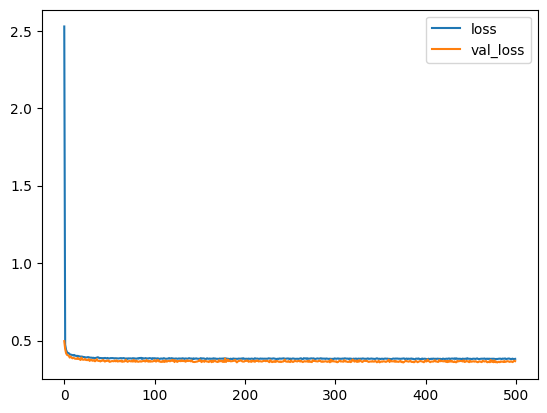

In [218]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

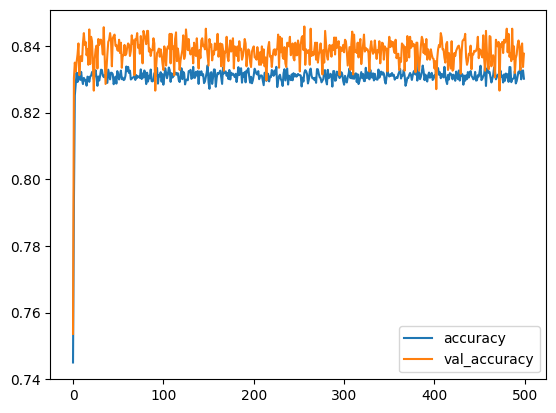

In [219]:
loss_df[['accuracy', 'val_accuracy']].plot()

In [220]:
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.3807860314846039, 0.8365405797958374]

Train data evaluation:
[0.37871402502059937, 0.8302602171897888]


In [221]:
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

y_test = np.argmax(y_test, axis=1)

142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


<Axes: >

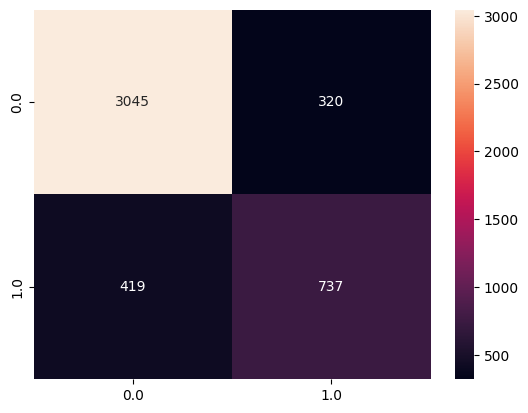

In [222]:
sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g', 
            xticklabels=categories, yticklabels=categories)

In [223]:
print(classification_report(y_test, test_predictions, target_names=["<=50K", ">50K"]))

acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

       <=50K       0.88      0.90      0.89      3365
        >50K       0.70      0.64      0.67      1156

    accuracy                           0.84      4521
   macro avg       0.79      0.77      0.78      4521
weighted avg       0.83      0.84      0.83      4521


Model overall accuracy: 83.65%


In [224]:
y.dtype

dtype('float64')

In [225]:
X.dtypes

age                                     float32
fnlwgt                                  float32
education.num                           float32
sex                                     float32
capital.gain                            float32
capital.loss                            float32
hours.per.week                          float32
workclass_Local-gov                     float32
workclass_Other                         float32
workclass_Private                       float32
workclass_Self-emp-inc                  float32
workclass_Self-emp-not-inc              float32
workclass_State-gov                     float32
education_Assoc-acdm                    float32
education_Assoc-voc                     float32
education_Bachelors                     float32
education_HS-grad                       float32
education_High-school                   float32
education_Masters                       float32
education_Other                         float32
education_Some-college                  

In [226]:
roc_auc_score(y, model.predict(X), multi_class="ovr")

942/942 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


0.890300234223143

I keep having problems with inconsistent numbers of samples, I will try to solve it tomorrow
Fixed the problem, now I have to try it with imaginary numbers and write my analysis